In [155]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

image: (512, 512)   min: 0.0   max: 0.949019607843
kernel: (32, 32)   min: 0.0   max: 0.0627450980392


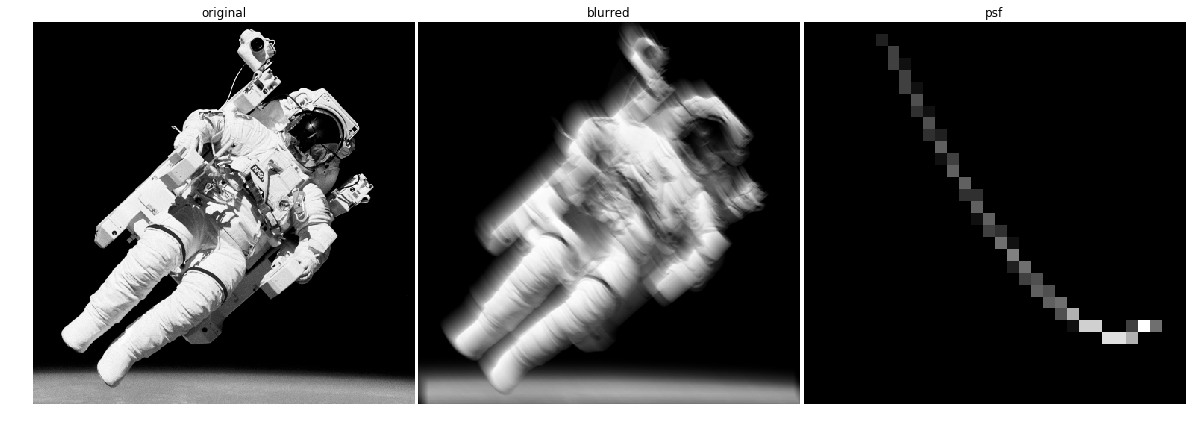

In [263]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, color
from scipy.signal import convolve2d as conv2
from skimage import color, data, restoration
from pprint import pprint

def showPics(pics, cols=2):
    
    plt.rcParams["figure.figsize"] = 16, 16
    n= len(pics)

    rows= int((n+1)/cols)

    r= 1
    c= 1
    i= 1
    
    for pic in pics:
        if (c>cols):
            c= 0
            r+= 1
        
        plt.subplot(rows, cols, i)
        plt.imshow(pic[0])
        plt.title(pic[1])
        
        i+= 1
        c+= 1
        plt.axis('off')
            
    plt.gray()
    plt.subplots_adjust(wspace=0.01, hspace=0.1, top=1, bottom=0, left=0, right=1)
    plt.show()    
    
    return


original= io.imread('scaled.png')
blurred= io.imread('blurred.png')/255
kernel= np.load("swirl.npy")

print ("image:" , blurred.shape , "  min:" , np.min(blurred), "  max:" , np.max(blurred))
print ("kernel:" , kernel.shape , "  min:" , np.min(kernel), "  max:" , np.max(kernel))

showPics([
    [original, "original"], 
    [blurred, "blurred"],
    [psf, "psf"]],3)


psf: (32, 32)   min: 0.001   max: 0.0637450980392
image: (512, 512)   min: -0.000117647058824   max: 0.949960784314

RL deconv 20 iterations


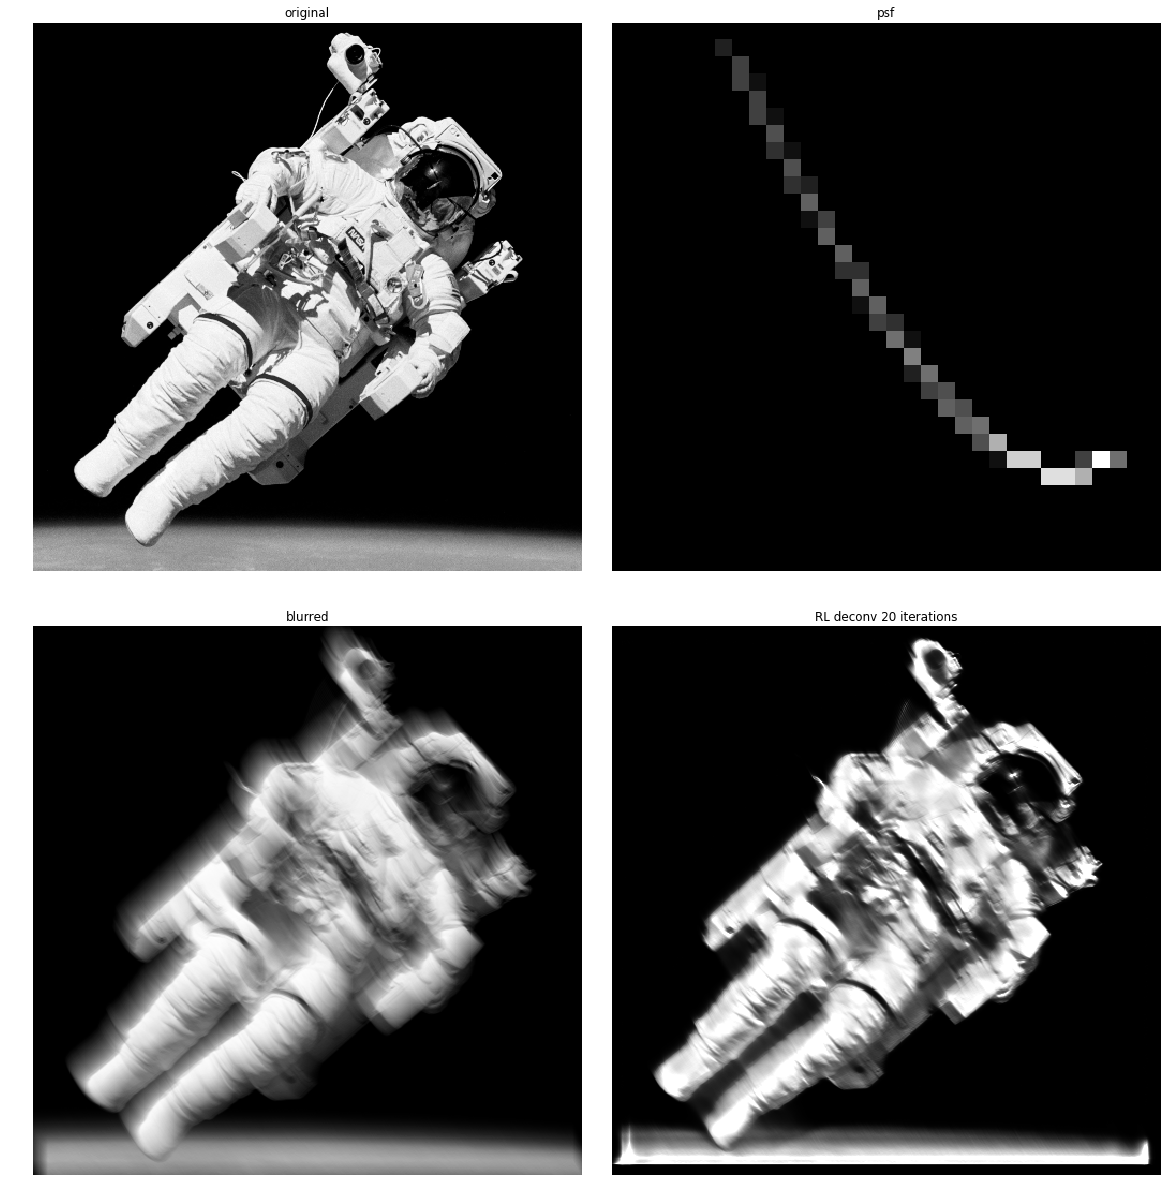

In [265]:
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv2
from skimage import color, data, restoration
from pprint import pprint




psf = kernel + 0.001
astro = blurred.astype(float).copy()


#astro= color.rgb2gray(data.astronaut())
#psf = np.ones((5, 5)) / 25

astro= astro.copy() + (np.random.poisson(lam=25, size=astro.shape) - 10) / 25500.



print ("psf:" , psf.shape , "  min:" , np.min(psf), "  max:" , np.max(psf))
print ("image:" , astro.shape , "  min:" , np.min(astro), "  max:" , np.max(astro))

    
runs= 20
    
print()
print ('RL deconv ' + str(runs) + " iterations")

# Restore Image using Richardson-Lucy algorithm
deconv = restoration.richardson_lucy(astro, psf, iterations= runs)

#fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 12))


showPics([
    [original, "original"], 
    [psf, "psf"], 
    [blurred, "blurred"],
    [deconv, 'RL deconv ' + str(runs) + " iterations"]])




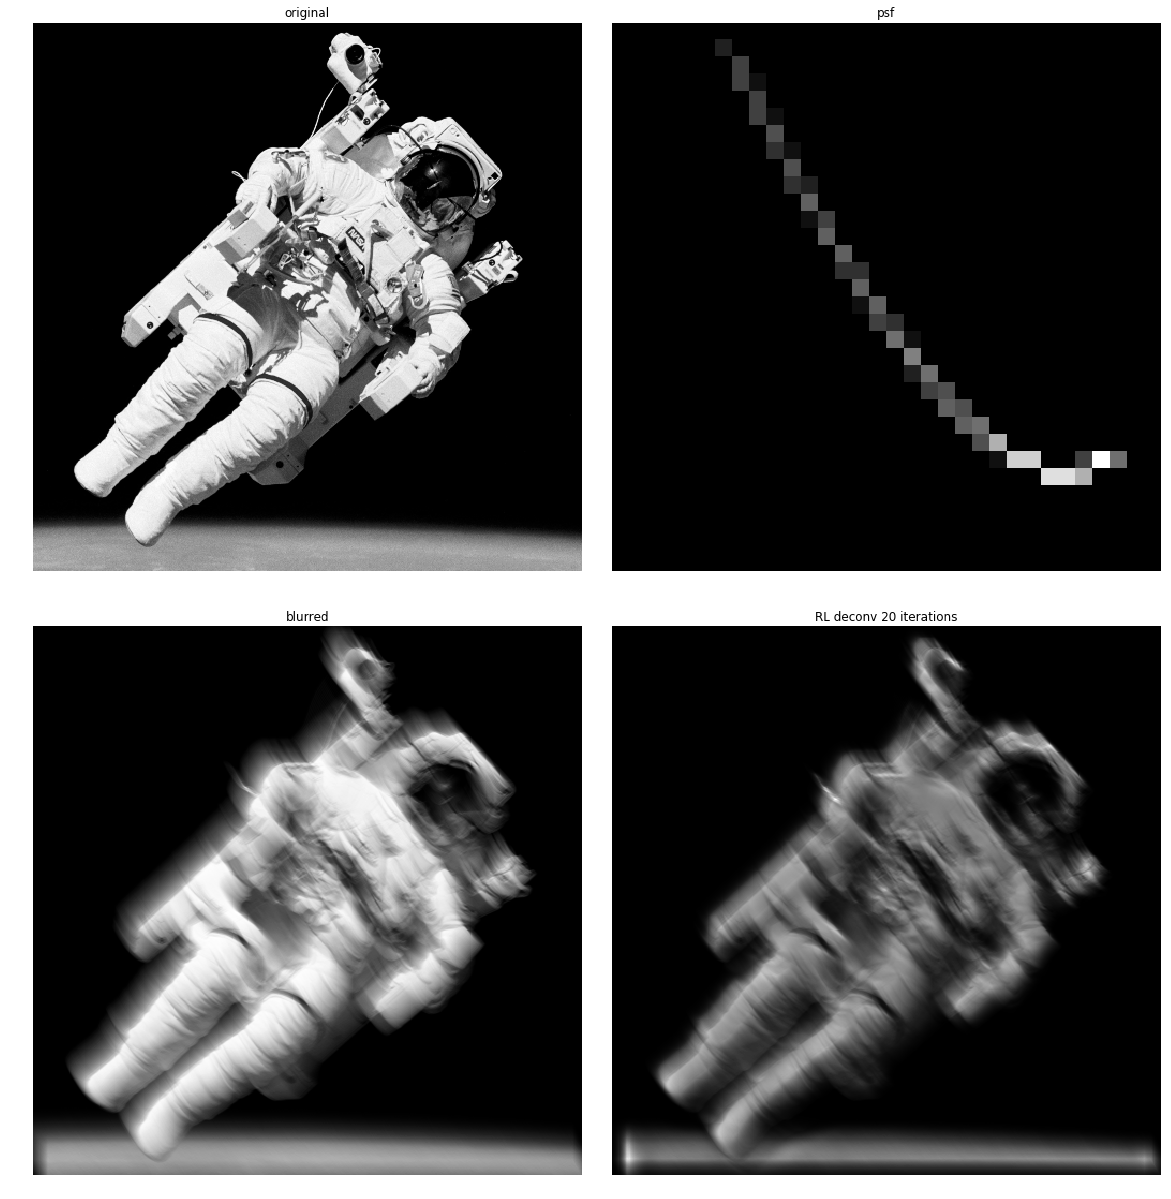

In [266]:
import scipy

def RL_deconv(image, psf, iterations):
   
    latent_est = image.copy()
  
    fsp = np.flipud(np.flipud(psf.copy()))
    
    fsp.dtype
    
    for i in range(1, iterations):
        
        est_conv      = scipy.signal.convolve2d(latent_est, psf, 'same')
        relative_blur = np.divide(image, est_conv)
        error_est     = conv2(relative_blur,fsp,'same') 
        latent_est    = np.multiply(latent_est, error_est)
    
    return latent_est

deco= RL_deconv(astro, psf, 5)

showPics([ 
    [original, "original"], 
    [psf, "psf"], 
    [blurred, "blurred"],
    [deco, 'RL deconv ' + str(runs) + " iterations"]])